In [1]:
!which python

/home/user/jfayzullaev/stellar-clustering/.venv-vis/bin/python


In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
TX_EMB = "../transactions_node2vec_kmeans_results.csv"
TX_EDGES = "../../../data/transaction_edges_mv.csv" 

In [6]:
tx_df = pd.read_csv(TX_EMB, usecols=["account_id", "kmeans_10"])
tx_df["account_id"] = tx_df["account_id"].astype("int64")

In [7]:
edges = pd.read_csv(TX_EDGES, usecols=["sender_id", "receiver_id"])
edges["sender_id"] = edges["sender_id"].astype("int64")
edges["receiver_id"] = edges["receiver_id"].astype("int64")

In [8]:
G_tx = nx.Graph()
G_tx.add_edges_from(edges.itertuples(index=False, name=None))
del edges  

## Top-5 clusters (k=10)

In [9]:
def top5_sizes(df, kcol):
    total = len(df)
    s = (df[kcol]
         .value_counts()
         .rename_axis("cluster_id")
         .reset_index(name="n_accounts")
         .sort_values("n_accounts", ascending=False)
         .head(5))
    s["pct_of_all"] = (s["n_accounts"] / total * 100).round(2)
    s.insert(0, "k", int(kcol.split("_")[1]))
    return s

In [10]:
def per_cluster_stats(df, kcol, G, top_ids):
    rows = []
    nodes_in_G = set(G.nodes)
    total = len(df)
    for cid in top_ids:
        comm_nodes = set(df.loc[df[kcol] == cid, "account_id"])
        comm_nodes_in_G = list(comm_nodes & nodes_in_G)

        sub = G.subgraph(comm_nodes_in_G).copy()
        n_nodes = sub.number_of_nodes()
        n_edges = sub.number_of_edges()
        density = nx.density(sub) if n_nodes > 1 else 0.0
        avg_degree = (sum(dict(sub.degree()).values()) / n_nodes) if n_nodes > 0 else 0.0

        rows.append({
            "k": int(kcol.split("_")[1]),
            "cluster_id": cid,
            "size_in_partition": len(comm_nodes),
            "size_in_graph": n_nodes,
            "edges_in_graph": n_edges,
            "density": density,
            "avg_degree": avg_degree,
            "pct_of_all_nodes": round(len(comm_nodes) / total * 100, 2),
        })
    return pd.DataFrame(rows).sort_values("size_in_graph", ascending=False)

In [ ]:
tx_top10 = top5_sizes(tx_df, "kmeans_10")

print("Transactions — Top 5 clusters (k=10):")
display(tx_top10)

Transactions — Top 5 clusters (k=50):


,k,cluster_id,n_accounts,pct_of_all
0,10,6,71450,34.61
1,10,2,42882,20.77
2,10,3,37423,18.13
3,10,7,14592,7.07
4,10,0,12526,6.07


In [ ]:
tx_top10_stats = per_cluster_stats(tx_df, "kmeans_10", G_tx, tx_top10["cluster_id"].tolist())

print("Transactions — Per-cluster stats for Top 5 (k=10):")
display(tx_top10_stats)

Transactions — Per-cluster stats for Top 5 (k=50):


,k,cluster_id,size_in_partition,size_in_graph,edges_in_graph,density,avg_degree,pct_of_all_nodes
0,10,6,71450,71450,72158,0.000028,2.019818,34.61
1,10,2,42882,42882,42904,0.000047,2.001026,20.77
2,10,3,37423,37423,37401,0.000053,1.998824,18.13
3,10,7,14592,14592,16560,0.000156,2.269737,7.07
4,10,0,12526,12526,25548,0.000326,4.079195,6.07


Large groups (20–25k accounts) where almost every account has degree = 0 (no transactions inside).

### Plot the Degree Distribution for top 5 

In [13]:
def plot_degree_hist_for_top5(G, df, top_table, kcol, bins=50):
    nodes_in_G = set(G.nodes)
    for cid in top_table["cluster_id"]:
        comm_nodes = set(df.loc[df[kcol] == cid, "account_id"])
        sub_nodes = list(comm_nodes & nodes_in_G)
        sub = G.subgraph(sub_nodes)
        degs = [d for _, d in sub.degree()]
        if not degs:
            continue
        plt.figure(figsize=(6, 4))
        plt.hist(degs, bins=bins)
        plt.yscale("log")
        plt.xlabel("Degree (undirected)")
        plt.ylabel("Count")
        plt.title(f"TX degree distribution — {kcol} cluster {cid} (n={len(degs)})")
        plt.tight_layout()
        plt.show()

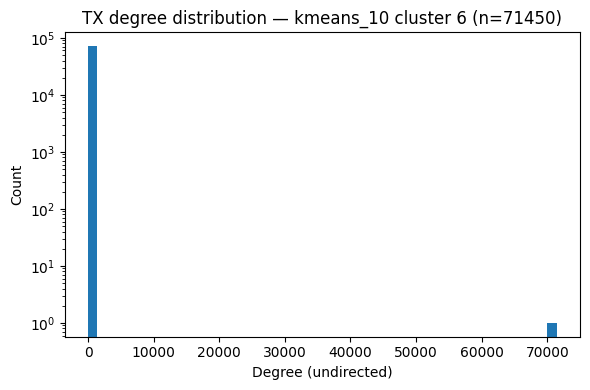

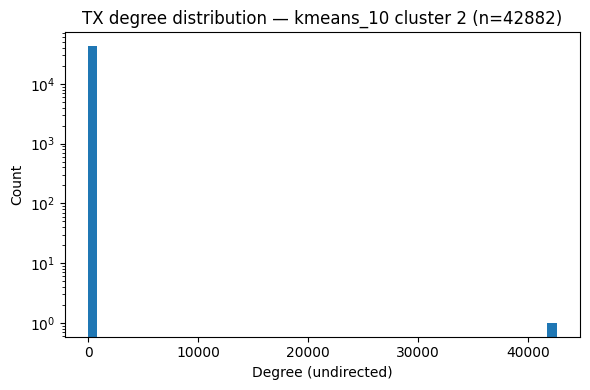

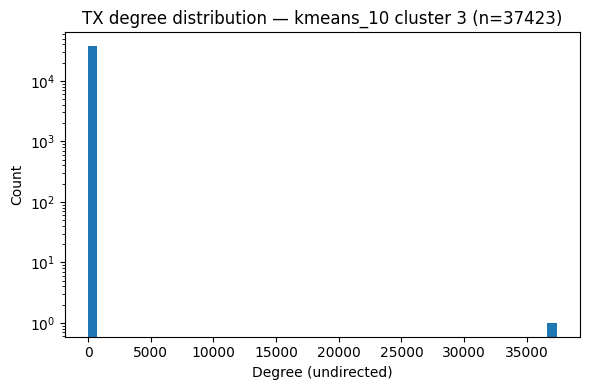

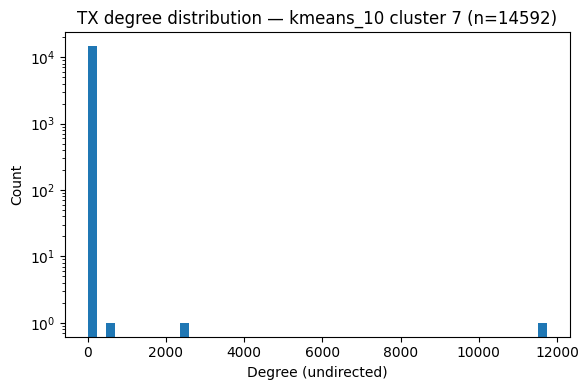

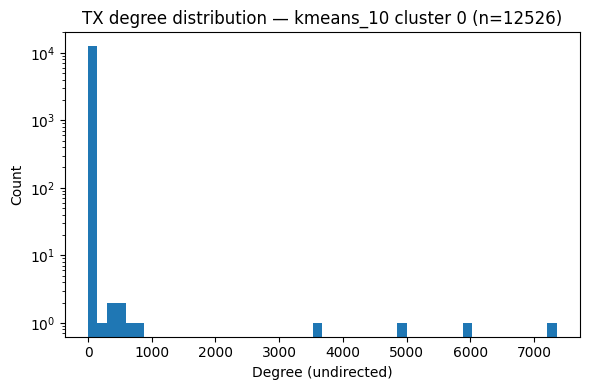

In [14]:
# k=50
plot_degree_hist_for_top5(G_tx, tx_df, tx_top10, "kmeans_10", bins=50)


### Bind to metadata

In [15]:
NODES_CSV   = "~/stellar-clustering/network/data/new/account_nodes_all_mv.csv"
FEATS_CSV   = "~/stellar-clustering/network/data/new/account_node_features_full_mv.csv"

In [16]:
assert {"account_id","kmeans_10"}.issubset(tx_df.columns)

In [17]:
df_nodes = pd.read_csv(NODES_CSV)                     
df_meta  = pd.read_csv(FEATS_CSV)  

In [18]:
tx_df["account_id"] = tx_df["account_id"].astype("int64", errors="ignore")
if "account_id" in df_nodes.columns:
    df_nodes["account_id"] = df_nodes["account_id"].astype("int64", errors="ignore")
df_meta["account_id"] = df_meta["account_id"].astype("int64", errors="ignore")

In [19]:
df_comm = tx_df[["account_id","kmeans_10"]].copy()

In [20]:
df_merged = df_comm.merge(df_meta, on="account_id", how="left")

In [22]:
overlap = df_comm["account_id"].isin(df_meta["account_id"]).sum()
print(f"Matched account IDs: {overlap} / {len(df_comm)}")

Matched account IDs: 206451 / 206451


In [23]:
df_merged.to_csv("tx_kmeans_with_metadata.csv", index=False)
print("Saved: tx_kmeans_with_metadata.csv")

Saved: tx_kmeans_with_metadata.csv


In [24]:
df_with_metadata = df_merged[df_merged["address"].notna()].copy()


### Bind with the normalized labels

In [27]:
NORM_LABELS = "../../../labled-data/labels/label-normalization/labels_entities_normalized.csv"

In [28]:
df_norm = (pd.read_csv(NORM_LABELS, usecols=["account_id","name"])
             .dropna(subset=["account_id","name"])
             .drop_duplicates(subset=["account_id"])
             .rename(columns={"name":"entity"}))

In [29]:
for col in ["account_id"]:
    try:
        tx_df[col] = tx_df[col].astype("Int64")
        df_norm[col] = df_norm[col].astype("Int64")
    except Exception:
        tx_df[col] = tx_df[col].astype(str)
        df_norm[col] = df_norm[col].astype(str)


In [ ]:
def bind_and_plot(tx_df, df_norm, kcol, topn=10):
    df_comm = tx_df[["account_id", kcol]].copy()
    df_matched = df_comm.merge(df_norm, on="account_id", how="inner")
    print(f"[{kcol}] Matched normalized-labeled accounts: {len(df_matched):,} / {len(df_comm):,} "
          f"({len(df_matched)/len(df_comm):.2%})")

    counts = (df_matched[kcol].value_counts().head(topn).sort_values(ascending=True))
    plt.figure(figsize=(7,4))
    counts.plot(kind="barh", title=f"TX {kcol}: Top clusters by # normalized-labeled accounts")
    plt.xlabel("Number of Labeled Accounts"); plt.ylabel("Cluster ID")
    plt.tight_layout(); plt.show()

    return df_matched

[kmeans_10] Matched normalized-labeled accounts: 397 / 206,451 (0.19%)


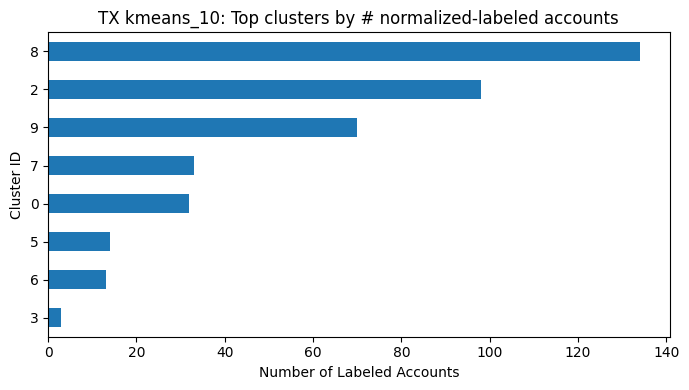

In [33]:
tx_matched_k10 = bind_and_plot(tx_df, df_norm, "kmeans_10", topn=10)

entity breakdown 

In [ ]:
def entity_breakdown(df_matched, kcol, topn=5):
    label_counts = (
        df_matched.groupby([kcol, "entity"])
        .size()
        .reset_index(name="count")
    )

    top_clusters = (
        label_counts.groupby(kcol)["count"]
        .sum()
        .sort_values(ascending=False)
        .head(topn)
        .index
        .tolist()
    )
    for cid in top_clusters:
        print(f"\nCluster {cid} — {kcol} — normalized entity breakdown:")
        sub = label_counts[label_counts[kcol] == cid].copy()
        sub["share"] = (sub["count"] / sub["count"].sum()).round(3)
        display(sub.sort_values("count", ascending=False))

In [34]:
entity_breakdown(tx_matched_k10, "kmeans_10", topn=5)


Cluster 8 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
32,8,SCAM,124,0.925
34,8,TMM bot,3,0.022
29,8,EXLM,3,0.022
30,8,Lobstr,1,0.007
28,8,AQUA,1,0.007
31,8,RippleFox,1,0.007
33,8,Spam Issuer,1,0.007



Cluster 2 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
11,2,SCAM,51,0.520
5,2,Coinbase,16,0.163
12,2,SDF,11,0.112
18,2,Wirex,3,0.031
16,2,UltraCapital,2,0.020
2,2,AQUA,2,0.020
1,2,AADC,1,0.010
3,2,AnchorUSD,1,0.010
7,2,EXMO,1,0.010
6,2,CryptoCom,1,0.010



Cluster 9 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
59,9,SCAM,18,0.257
46,9,Coinbase,16,0.229
35,9,Binance,6,0.086
40,9,Blockchain.com,3,0.043
43,9,Centre,2,0.029
38,9,Bitpanda,2,0.029
61,9,Upbit,2,0.029
36,9,Bitfinex,1,0.014
42,9,CEX.IO,1,0.014
41,9,"CAUTION 17,000x inflation, no buy market, claw...",1,0.014



Cluster 7 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
25,7,SCAM,30,0.909
24,7,Lobstr,1,0.030
26,7,UltraCapital,1,0.030
27,7,montelibero.org,1,0.030



Cluster 0 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
0,0,SCAM,32,1.0
